### 1. Dataset download and optimization

In [ ]:
import os
import shutil
import numpy as np
from PIL import Image
import gdown

if not os.path.isdir('dataset-splitted'):

  #Download dataset from google drive folder
  #Positive
  !gdown --id 15RkLfTQNknZPNOVRL60yDyht9sNdyUCP -O positiveFinal.zip
  #Negative
  !gdown --id 1hdjnMDhlDK8gCaRLM6bDxs2Uz6Q-A4Mn -O negativeFinal.zip

  #Prepare unzip and prepare dataset folder
  folder_path = r'datasetLarge'
  positive_zip = "positiveFinal.zip"
  negative_zip = "negativeFinal.zip"
  positive = "positive"
  negative = "negative"

  if not os.path.exists(folder_path):
      os.makedirs(folder_path)

  shutil.unpack_archive(positive_zip, folder_path)
  shutil.unpack_archive(negative_zip, folder_path)

  os.remove(positive_zip)
  os.remove(negative_zip)
  os.rename(folder_path+'/positiveFinal',folder_path+'/'+positive)
  os.rename(folder_path+'/negativeFinal',folder_path+'/'+negative)

  def optimize_positive(folder_path, threshold=0.8, central_ratio=0.5):
      count = 0
      color_rgba = [0, 0, 4, 255]  # Color to check

      for filename in os.listdir(folder_path):
          if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
              file_path = os.path.join(folder_path, filename)
              try:
                  image = Image.open(file_path)
                  mode = image.mode
                  width, height = 312,312
                  # Calculate the region of interest
                  central_width = int(width * central_ratio)
                  central_height = int(height * central_ratio)
                  left = (width - central_width) // 2
                  top = (height - central_height) // 2
                  right = left + central_width
                  bottom = top + central_height
                  # Crop the image to the central region
                  cropped_image = image.crop((left, top, right, bottom))
                  np_image = np.array(cropped_image)
                  color_pixels = np.sum(np.all(np_image == color_rgba, axis=-1))
                  total_pixels = central_width * central_height
                  color_ratio = color_pixels / total_pixels
                  if color_ratio <= threshold:
                      os.remove(file_path)
                      count = count+1
              except (IOError, OSError):
                  print(f"Failed to open image: {file_path}")
      return count

  def optimize_negative(folder_path, threshold=0.9, central_ratio=0.5):
      count = 0
      color_rgba = [0, 0, 4, 255]  # Color to check

      for filename in os.listdir(folder_path):
          if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
              file_path = os.path.join(folder_path, filename)
              try:
                  image = Image.open(file_path)
                  mode = image.mode
                  width, height = 312,312
                  # Calculate the region of interest
                  central_width = int(width * central_ratio)
                  central_height = int(height * central_ratio)
                  left = (width - central_width) // 2
                  top = (height - central_height) // 2
                  right = left + central_width
                  bottom = top + central_height
                  # Crop the image to the central region
                  cropped_image = image.crop((left, top, right, bottom))
                  np_image = np.array(cropped_image)
                  color_pixels = np.sum(np.all(np_image == color_rgba, axis=-1))

                  total_pixels = central_width * central_height

                  color_ratio = color_pixels / total_pixels
                  if color_ratio >= threshold:
                      os.remove(file_path)
                      count = count+1
              except (IOError, OSError):
                  print(f"Failed to open image: {file_path}")
      return count


  print("Optimizes negatives: "+ str(optimize_negative(folder_path+'/'+negative)))
  print("Optimized positives: "+ str(optimize_positive(folder_path+'/'+positive)))

### 2. Imports and requirements

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.regularizers import l2
from keras.models import Model
import matplotlib.pyplot as plt
import pandas as pd
import os
import wave
import pylab
from pathlib import Path
from scipy import signal
from scipy.io import wavfile
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.applications import VGG19

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
import os
path = "datasetLarge"
print(os.listdir(path))
splitfolders.ratio(path,seed=1337, output="dataset-splitted", ratio=(0.6,0.2,0.2))

In [ ]:
#Set the image dimension used to train the models 
OUTPUT_DIR = ''
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
BATCH_SIZE = 32
N_CHANNELS = 3


### 3. Dataset split and preparation

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory
dir="dataset-splitted"
train_dataset = image_dataset_from_directory(
    directory= dir+"/train",
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
     color_mode='rgb')
validation_dataset = image_dataset_from_directory(
    directory= dir+ "/val",
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
     color_mode='rgb',
    batch_size=BATCH_SIZE)
test_dataset = image_dataset_from_directory(
    directory=  dir+"/test",
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
     color_mode='rgb',
    batch_size=BATCH_SIZE)

In [ ]:
# Prepare datasets for modelling
def prepare(ds, augment=False):
    # Define transformation
    rescale = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1./255)])
    flip_and_rotate = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
    ])

    # Apply rescale to the datasets
    ds = ds.map(lambda x, y: (rescale(x, training=True), y))
    if augment: ds = ds.map(lambda x, y: (flip_and_rotate(x, training=True), y))
    return ds

train_dataset = prepare(train_dataset, augment=False)
valid_dataset = prepare(validation_dataset, augment=False)
test_dataset = prepare(test_dataset, augment=False)

### 4. Network creation and training

In [ ]:
from tensorflow.keras.applications import VGG19,VGG16, ResNet50, Xception
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten

N_EPOCHS = 100
list_model = []

def model_VGG19Based():
    conv_base= VGG19(weights=None,include_top=False,input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3))
    conv_base.trainable=False

    model = Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256,activation='relu'))
    model.add(layers.Dense(2,activation='sigmoid'))

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=optimizers.Adam(learning_rate=2e-4),
        metrics=['accuracy']
    )

    # Implement early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    )
    list_model.append(model)

    #history = model.fit(train_dataset, epochs=N_EPOCHS, batch_size=32,validation_data=valid_dataset,callbacks=[early_stopping])
    history = model.fit(train_dataset, epochs=N_EPOCHS, batch_size=32,validation_data=valid_dataset)
    history_dict = history.history

    return history_dict

def model_VGG16Based():
    conv_base= VGG16(weights=None,include_top=False,input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3))
    conv_base.trainable=False

    model = Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256,activation='relu'))
    model.add(layers.Dense(2,activation='sigmoid'))

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=optimizers.Adam(learning_rate=2e-4),
        metrics=['accuracy']
    )

    # Implement early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    )

    list_model.append(model)

    #history = model.fit(train_dataset, epochs=N_EPOCHS, batch_size=32,validation_data=valid_dataset,callbacks=[early_stopping])
    history = model.fit(train_dataset, epochs=N_EPOCHS, batch_size=32,validation_data=valid_dataset)
    history_dict = history.history

    return history_dict

def model_ResNet50Based():
    conv_base= ResNet50(weights=None,include_top=False,input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3))
    conv_base.trainable=False

    model = Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256,activation='relu'))
    model.add(layers.Dense(2,activation='sigmoid'))

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=optimizers.Adam(learning_rate=2e-4),
        metrics=['accuracy']
    )

    # Implement early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    )

    list_model.append(model)

    #history = model.fit(train_dataset, epochs=N_EPOCHS, batch_size=32,validation_data=valid_dataset,callbacks=[early_stopping])
    history = model.fit(train_dataset, epochs=N_EPOCHS, batch_size=32,validation_data=valid_dataset)
    history_dict = history.history

    return history_dict

def model_XceptionBased():
    conv_base= Xception(weights=None,include_top=False,input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,3))
    conv_base.trainable=False

    model = Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256,activation='relu'))
    model.add(layers.Dense(2,activation='sigmoid'))

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=optimizers.Adam(learning_rate=2e-4),
        metrics=['accuracy']
    )

    # Implement early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True
    )

    list_model.append(model)

    #history = model.fit(train_dataset, epochs=N_EPOCHS, batch_size=32,validation_data=valid_dataset,callbacks=[early_stopping])
    history = model.fit(train_dataset, epochs=N_EPOCHS, batch_size=32,validation_data=valid_dataset)
    history_dict = history.history

    return history_dict

list_dist = []

list_dist.append(model_XceptionBased())
list_dist.append(model_ResNet50Based())
list_dist.append(model_VGG19Based())
list_dist.append(model_VGG16Based())


### 5. Loss and accuracy curves

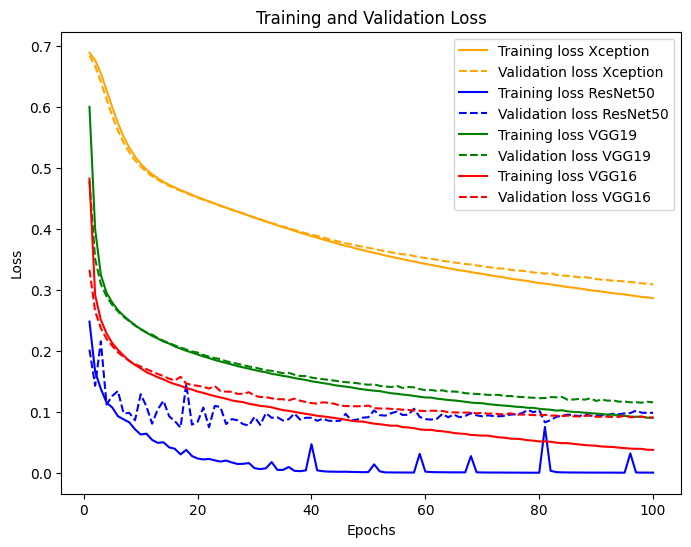

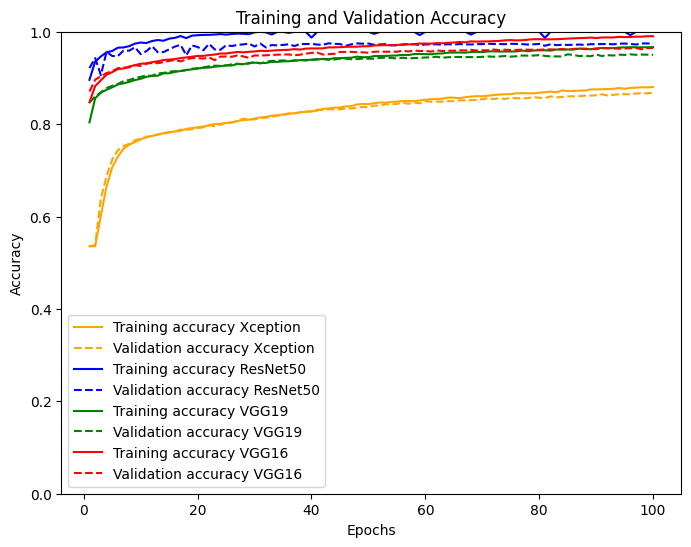

In [ ]:
import matplotlib.pyplot as plt

list_color = ['orange', 'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']
list_label = ['Xception','ResNet50', 'VGG19', 'VGG16']

# Plot the loss curves for training and validation
fig = plt.figure(figsize=(8, 6))
for i, history_dict in enumerate(list_dist):
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, len(loss_values) + 1)
    # Cycle through the colors in list_color
    color_train = list_color[i % len(list_color)]
    plt.plot(epochs, loss_values, color=color_train, label=f'Training loss {list_label[i]}')
    plt.plot(epochs, val_loss_values, color=color_train, linestyle='dashed', label=f'Validation loss {list_label[i]}')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

fig.savefig('loss.png', dpi=fig.dpi)

# Plot the accuracy curves for training and validation
fig = plt.figure(figsize=(8, 6))
for i, history_dict in enumerate(list_dist):
    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']
    epochs = range(1, len(acc_values) + 1)

    # Cycle through the colors in list_color
    color_train = list_color[i % len(list_color)]

    plt.plot(epochs, acc_values, color=color_train, label=f'Training accuracy {list_label[i]}')
    plt.plot(epochs, val_acc_values, color=color_train, linestyle='dashed', label=f'Validation accuracy {list_label[i]}')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()
plt.show()

fig.savefig('accuracy.png', dpi=fig.dpi)

### 6. Model test and evaluation

In [ ]:
# Compute the final loss and accuracy
for i, model in enumerate(list_model):
  result = model.evaluate(test_dataset, verbose=0)
  print("EVALUATION ",list_label[i],": Final loss: {0:.6f}, final accuracy: {1:.6f}".format(result[0], result[1]))

import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix


for i, model in enumerate(list_model):
  # Predict probabilities using the model
  predictions = []
  true_labels = []
  for images, labels in test_dataset:
      predictions_batch = model.predict(images, verbose = 0)
      predictions.extend(predictions_batch)
      true_labels.extend(labels.numpy())

  predictions = np.array(predictions)
  true_labels = np.array(true_labels)

  # Compute the final loss using the true labels and predicted probabilities
  final_loss = np.mean(
      tf.keras.losses.sparse_categorical_crossentropy(true_labels, predictions).numpy()
  )

# Calculate accuracy by comparing predicted labels with true labels
  predicted_labels = np.argmax(predictions, axis=1)
  accuracy = np.mean(predicted_labels == true_labels)
  print('-------------------',list_label[i],'-------------------')
  final_precision_score = precision_score(true_labels,predicted_labels)
  print("PRECISION: {0:.6f}".format(final_precision_score))
  final_recall = recall_score(true_labels,predicted_labels)
  print("RECALL: {0:.6f}".format(final_recall))
  final_f1_score = f1_score(true_labels,predicted_labels)
  print("F1 SCORE: {0:.6f}".format(final_f1_score))
  final_roc_auc_score = roc_auc_score(true_labels,predicted_labels)
  print("ROC AUC: {0:.6f}".format(final_roc_auc_score))
  final_avg_prec_score = average_precision_score(true_labels,predicted_labels)
  print("Average precision score: {0:.6f}".format(final_avg_prec_score))
  tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
  specificity = tn / (tn+fp)
  sensitivity = fn / (tn+fp)
  print("specificity: {0:.6f}".format(specificity))
  print("sensitivity: {0:.6f}".format(sensitivity))

